In [1]:
#Udai Nagpal, 
# -----------Part 5(iv)------------
import numpy as np
import math
from numpy import linalg as LA

#Element by element sigmoid of column vector
def sigmoid(x):
    output = np.zeros((x.shape[0], 1))
    for i in range(x.shape[0]):
        output[i,0] = 1.0/(1.0+math.exp(-x[i,0]))
    return output

#Scalar sigmoid
def sigmoid_deriv_scalar(x):
    sig_x = 1.0/(1.0+math.exp(-x))
    return sig_x * (1-sig_x)

def sigmoid_scalar(x):
    return 1.0/(1.0+math.exp(-x))

#Element by element sigmoid derivative of column vector
def sigmoid_deriv(x):
    output = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        temp_arr = np.zeros((1,1))
        temp_arr[0][0] = x[i,0]
        output[i,0] = sigmoid(temp_arr) * (1 - sigmoid(temp_arr))
    return output
y = np.array([[1],[2],[-1],[-3]])
print(sigmoid(y))
print(sigmoid_deriv(y))

[[ 0.73105858]
 [ 0.88079708]
 [ 0.26894142]
 [ 0.04742587]]
[[ 0.19661193]
 [ 0.10499359]
 [ 0.19661193]
 [ 0.04517666]]


In [2]:
def stochastic_gradient_descent (input_data, output_data, inter_layer_sizes, convergence_cutoff=0.00001, max_iterations=50, minibatch_size=25, learning_rate=0.2):
    layer_sizes = [len(input_data[0])] + inter_layer_sizes + [len(output_data[0])]
    num_layers = len(layer_sizes)
    #Random Initialization
    W = [np.random.uniform(low=-2.0, high=2.0, size=(layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
    dW = [[np.zeros((layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)] for j in range(minibatch_size)]
    b = [np.random.uniform(low=-2.0, high=2.0, size=(layer_sizes[i+1],)) for i in range(num_layers-1)]
    db = [[np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)] for j in range(minibatch_size)]
    abs_adjustments_W = [100*np.ones((layer_sizes[i],layer_sizes[i+1])) for i in range(num_layers-1)]
    abs_adjustments_b = [100*np.ones((layer_sizes[i+1],)) for i in range(len(layer_sizes)-1)]
    #print('W:' + str(W))
    #print('b:' + str(b))
    elapsed_iterations = 0
    max_adjustment_W, max_adjustment_b = 100, 100
    while(elapsed_iterations<max_iterations and max_adjustment_W>=convergence_cutoff and max_adjustment_b>=convergence_cutoff):
        stochastic_sample = np.random.choice(a=len(output_data),size=minibatch_size, replace=False)
        sample_inputs = [input_data[i] for i in stochastic_sample]
        sample_outputs = [output_data[i] for i in stochastic_sample]
        dW_sum = [np.zeros((layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
        db_sum = [np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)]
        sample_predictions = []
        running_cost = 0
        for sample in range(len(sample_outputs)):
            x = sample_inputs[sample]
            y = sample_outputs[sample]
            #print('sample input: ' + str(x))
            #print('sample output: ' + str(y))
            saved_forward_pass = [x]
            layer_input = x
            #Forward Pass
            for layer in range(num_layers-1):
                layer_output = np.add(np.dot(np.transpose(W[layer]), layer_input),b[layer])
                out_dim = layer_output.shape[0]
                layer_input = sigmoid(np.reshape(layer_output, (out_dim,1)))
                layer_input = np.hstack(layer_input)
                saved_forward_pass.append(layer_input)
            sample_prediction = np.array(saved_forward_pass[-1:])
            running_cost += LA.norm(np.subtract(sample_prediction, np.array(y)))**2.0
            #BACKPROPAGATION
            deltas = [np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)]
            for output_component in range(len(deltas[num_layers-2])):
                deltas[num_layers-2][output_component] = -1.0 * (y[output_component]-saved_forward_pass[-1][output_component])*saved_forward_pass[-1][output_component]*(1-saved_forward_pass[-1][output_component])
            #Backpropagating Deltas
            for layer in range(num_layers-3, -1, -1):
                for neuron_ind in range(len(saved_forward_pass[layer+1])):
                    sigmoid_val = saved_forward_pass[layer+1][neuron_ind]
                    partial_sigmoid = (sigmoid_val) * (1 - sigmoid_val)
                    corr_weights = np.array(W[layer+1][neuron_ind,:])
                    corr_deltas = np.array(deltas[layer+1])
                    deltas[layer][neuron_ind] = partial_sigmoid * np.dot(corr_weights, corr_deltas)
            #Computing gradient of cost function w.r.t. W and b
            for layer in range(num_layers-1):
                for j in range(len(saved_forward_pass[layer+1])):
                    for i in range(len(saved_forward_pass[layer])):
                        dW[sample][layer][i,j] = deltas[layer][j] * saved_forward_pass[layer][i]
                    db[sample][layer][j] = deltas[layer][j]
            for i in range(len(dW_sum)):
                dW_sum[i] = np.add(dW_sum[i], dW[sample][i])
            #print(dW[sample])
            #dW_sum = np.add(dW_sum, dW[sample])
            db_sum = np.add(db_sum,db[sample])
            #print('deltas: ' + str(deltas))
            #print('dW: ' + str(dW))
            #print('db: ' + str(db))
        print("Cost Function: " + str(running_cost/(2.0*minibatch_size)))
        #print('dW sum: ' + str(dW_sum))
        db_avg = db_sum / minibatch_size
        dW_avg = [dWi/minibatch_size for dWi in dW_sum]
        #Updating Weight Parameters and Checking for Convergence
        max_adjustment_W = 0
        max_adjustment_b = 0
        for layer in range(num_layers-1):
            W[layer] = W[layer] - learning_rate * dW_avg[layer]
            b[layer] = b[layer] - learning_rate * db_avg[layer]
            adj_W = np.absolute(learning_rate * dW_avg[layer])
            adj_b = np.absolute(learning_rate * db_avg[layer])
            if (np.amax(adj_W) > max_adjustment_W):
                max_adjustment_W = np.amax(adj_W)
            if (np.amax(adj_b) > max_adjustment_b):
                max_adjustment_b = np.amax(adj_b)
        #print('Updated W: ' + str(W))
        #print('Updated b: ' + str(b))
        elapsed_iterations += 1
        #print(elapsed_iterations)
    #Final Output Predictions from Trained Model  
    final_pred_outputs = []
    for input_point in input_data:
        forward_pass = [input_point]
        layer_input = input_point
        for layer in range(num_layers-1):
            layer_output = np.add(np.dot(np.transpose(W[layer]), layer_input),b[layer])
            #print(layer_output)
            out_dim = layer_output.shape[0]
            layer_input = sigmoid(np.reshape(layer_output, (out_dim,1)))
            layer_input = np.hstack(layer_input)
            forward_pass.append(layer_input)
        #print(forward_pass)
        final_pred_outputs.append(forward_pass[-1:])
    final_pred_outputs = [output.tolist() for out_list in final_pred_outputs for output in out_list]
    print("Final W: " + str(W))
    print("Final b: " + str(b))
    #print("Actual Outputs: " + str(output_data))
    #print("Predicted Outputs: " + str(final_pred_outputs))
    print("Total Elapsed Iterations: " + str(elapsed_iterations))

In [4]:
#TEST OF STOCHASTIC GRADIENT DESCENT: COST FUNCTION IS INDEED MINIMIZED
my_input = [i.tolist() for i in np.random.uniform(size=(100,2))]
#print(my_input)
my_output = []
for j in range(len(my_input)):
    my_output.append([sigmoid_scalar(1*my_input[j][0] +2*my_input[j][1] - 1), sigmoid_scalar(1.2*my_input[j][0] +1.7*my_input[j][1] - 1.3)])
my_output = np.array(my_output)
#print(my_output)
stochastic_gradient_descent(my_input, my_output, [2,2])

Cost Function: 0.156231049786
Cost Function: 0.159740322576
Cost Function: 0.160057778377
Cost Function: 0.147027317363
Cost Function: 0.155465616476
Cost Function: 0.153851317329
Cost Function: 0.148510155907
Cost Function: 0.144153679224
Cost Function: 0.149323240955
Cost Function: 0.14106771221
Cost Function: 0.149206547173
Cost Function: 0.153574321679
Cost Function: 0.151608760867
Cost Function: 0.147690681693
Cost Function: 0.137186667238
Cost Function: 0.142330538178
Cost Function: 0.144460264871
Cost Function: 0.139734603204
Cost Function: 0.138926241288
Cost Function: 0.13424620883
Cost Function: 0.138873533803
Cost Function: 0.137039643538
Cost Function: 0.127366305131
Cost Function: 0.127322829647
Cost Function: 0.127297536101
Cost Function: 0.125302342679
Cost Function: 0.120499420844
Cost Function: 0.12627019452
Cost Function: 0.120172166608
Cost Function: 0.122818138936
Cost Function: 0.124232809718
Cost Function: 0.114663283842
Cost Function: 0.112477619517
Cost Function

In [10]:
def adam (input_data, output_data, inter_layer_sizes, convergence_cutoff=0.001, 
          max_iterations=3000, minibatch_size=100, learning_rate=0.0015):
    
    # initialize variables
    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 10**(-8.0)
    layer_sizes = [len(input_data[0])] + inter_layer_sizes + [len(output_data[0])]
    num_layers = len(layer_sizes)
    
    #Random Initialization
    W = [np.random.uniform(low=-1.0, high=1.0, size=(layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
    dW = [[np.zeros((layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)] for j in range(minibatch_size)]
    b = [np.random.uniform(low=-1.0, high=1.0, size=(layer_sizes[i+1],)) for i in range(num_layers-1)]
    db = [[np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)] for j in range(minibatch_size)]
    m = [np.zeros((layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
    v = [np.zeros((layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
    m_b = [np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)]
    v_b = [np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)]
    abs_adjustments_W = [100*np.ones((layer_sizes[i],layer_sizes[i+1])) for i in range(num_layers-1)]
    abs_adjustments_b = [100*np.ones((layer_sizes[i+1],)) for i in range(len(layer_sizes)-1)]
    #print('W:' + str(W))
    #print('b:' + str(b))
    elapsed_iterations = 0
    max_adjustment_W, max_adjustment_b = 100, 100
    while(elapsed_iterations<max_iterations and max_adjustment_W>=convergence_cutoff and max_adjustment_b>=convergence_cutoff):
        stochastic_sample = np.random.choice(a=len(output_data),size=minibatch_size, replace=False)
        sample_inputs = [input_data[i] for i in stochastic_sample]
        sample_outputs = [output_data[i] for i in stochastic_sample]
        dW_sum = [np.zeros((layer_sizes[i],layer_sizes[i+1])) for i in range(len(layer_sizes)-1)]
        db_sum = [np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)]
        sample_predictions = []
        running_cost = 0
        for sample in range(len(sample_outputs)):
            x = sample_inputs[sample]
            y = sample_outputs[sample]
            #print('sample input: ' + str(x))
            #print('sample output: ' + str(y))
            saved_forward_pass = [x]
            layer_input = x
            #Forward Pass
            for layer in range(num_layers-1):
                layer_output = np.add(np.dot(np.transpose(W[layer]), layer_input),b[layer])
                out_dim = layer_output.shape[0]
                layer_input = sigmoid(np.reshape(layer_output, (out_dim,1)))
                layer_input = np.hstack(layer_input)
                saved_forward_pass.append(layer_input)
            sample_prediction = np.array(saved_forward_pass[-1:])
            running_cost += LA.norm(np.subtract(sample_prediction, np.array(y)))**2.0
            #BACKPROPAGATION
            deltas = [np.zeros((layer_sizes[i+1],)) for i in range(num_layers-1)]
            for output_component in range(len(deltas[num_layers-2])):
                deltas[num_layers-2][output_component] = -1.0 * (y[output_component]-saved_forward_pass[-1][output_component])*saved_forward_pass[-1][output_component]*(1-saved_forward_pass[-1][output_component])
            #Backpropagating Deltas
            for layer in range(num_layers-3, -1, -1):
                for neuron_ind in range(len(saved_forward_pass[layer+1])):
                    sigmoid_val = saved_forward_pass[layer+1][neuron_ind]
                    partial_sigmoid = (sigmoid_val) * (1 - sigmoid_val)
                    corr_weights = np.array(W[layer+1][neuron_ind,:])
                    corr_deltas = np.array(deltas[layer+1])
                    deltas[layer][neuron_ind] = partial_sigmoid * np.dot(corr_weights, corr_deltas)
            #Computing gradient of cost function w.r.t. W and b
            for layer in range(num_layers-1):
                for j in range(len(saved_forward_pass[layer+1])):
                    for i in range(len(saved_forward_pass[layer])):
                        dW[sample][layer][i,j] = deltas[layer][j] * saved_forward_pass[layer][i]
                    db[sample][layer][j] = deltas[layer][j]
            for i in range(len(dW_sum)):
                dW_sum[i] = np.add(dW_sum[i], dW[sample][i])
            #print(dW[sample])
            #dW_sum = np.add(dW_sum, dW[sample])
            db_sum = np.add(db_sum,db[sample])
            #print('deltas: ' + str(deltas))
            #print('dW: ' + str(dW))
            #print('db: ' + str(db))
        print("Cost Function: " + str(running_cost/(2.0*minibatch_size)))
        #print('dW sum: ' + str(dW_sum))
        db_avg = db_sum / minibatch_size
        dW_avg = [dWi/minibatch_size for dWi in dW_sum]
        #Updating Weight Parameters and Checking for Convergence
        max_adjustment_W = 0
        max_adjustment_b = 0
        for layer in range(num_layers-1):
            m[layer] = beta_1 * m[layer] + (1-beta_1)*dW_avg[layer]
            v[layer] = beta_2 * v[layer] + (1-beta_2)*np.square(dW_avg[layer])
            eps_matrix = epsilon * np.ones((np.shape(dW_avg[layer])[0], np.shape(dW_avg[layer])[1]))
            W[layer] = W[layer] - learning_rate * np.divide(m[layer], np.add(np.sqrt(v[layer]), eps_matrix))
            m_b[layer] = beta_1 * m_b[layer] + (1-beta_1)*db_avg[layer]
            v_b[layer] = beta_2 * v_b[layer] + (1-beta_2)*np.square(db_avg[layer])
            eps_matrix_b = epsilon * np.ones((np.shape(db_avg[layer])[0]))
            b[layer] = b[layer] - learning_rate * np.divide(m_b[layer], np.add(np.sqrt(v_b[layer]), eps_matrix_b))
            #b[layer] = b[layer] - learning_rate * db_avg[layer]
            adj_W = np.absolute(learning_rate * np.divide(m[layer], np.add(np.sqrt(v[layer]), eps_matrix)))
            adj_b = np.absolute(learning_rate * np.divide(m_b[layer], np.add(np.sqrt(v_b[layer]), eps_matrix_b)))
            if (np.amax(adj_W) > max_adjustment_W):
                max_adjustment_W = np.amax(adj_W)
            if (np.amax(adj_b) > max_adjustment_b):
                max_adjustment_b = np.amax(adj_b)
        #print('Updated W: ' + str(W))
        #print('Updated b: ' + str(b))
        elapsed_iterations += 1
        print(elapsed_iterations)
    #Final Output Predictions from Trained Model  
    final_pred_outputs = []
    for input_point in input_data:
        forward_pass = [input_point]
        layer_input = input_point
        for layer in range(num_layers-1):
            layer_output = np.add(np.dot(np.transpose(W[layer]), layer_input),b[layer])
            #print(layer_output)
            out_dim = layer_output.shape[0]
            layer_input = sigmoid(np.reshape(layer_output, (out_dim,1)))
            layer_input = np.hstack(layer_input)
            forward_pass.append(layer_input)
        #print(forward_pass)
        final_pred_outputs.append(forward_pass[-1:])
    final_pred_outputs = [output.tolist() for out_list in final_pred_outputs for output in out_list]
    print("Final W: " + str(W))
    print("Final b: " + str(b))
    #print("Actual Outputs: " + str(output_data))
    #print("Predicted Outputs: " + str(final_pred_outputs))
    print("Total Elapsed Iterations: " + str(elapsed_iterations))
    return final_pred_outputs

#Testing adam
# adam(input_data=my_input, output_data = my_output, inter_layer_sizes=[2,2],max_iterations=50, minibatch_size=15)

Cost Function: 0.0298369767451
1
Cost Function: 0.0263402810137
2
Cost Function: 0.0259282295756
3
Cost Function: 0.0238654252753
4
Cost Function: 0.0288002949
5
Cost Function: 0.0221061809433
6
Cost Function: 0.0207873180506
7
Cost Function: 0.02313106379
8
Cost Function: 0.0184500253377
9
Cost Function: 0.0187499866487
10
Cost Function: 0.0219119433843
11
Cost Function: 0.0257842426097
12
Cost Function: 0.0171581063298
13
Cost Function: 0.017330658865
14
Cost Function: 0.0109349929875
15
Cost Function: 0.0198879563541
16
Cost Function: 0.0253672779659
17
Cost Function: 0.0210087190843
18
Cost Function: 0.024650385688
19
Cost Function: 0.0219825612881
20
Cost Function: 0.0213217539047
21
Cost Function: 0.0170667431294
22
Cost Function: 0.0141456462095
23
Cost Function: 0.0226732415009
24
Cost Function: 0.0192778949118
25
Cost Function: 0.0199802544353
26
Cost Function: 0.0165957066534
27
Cost Function: 0.0181236171131
28
Cost Function: 0.0171354934455
29
Cost Function: 0.017356401058


[[0.641936009264996, 0.5600435174923388],
 [0.638048933879993, 0.5533223615749285],
 [0.6429240809298, 0.5616109819650115],
 [0.6407042528459561, 0.5581778865466135],
 [0.6391173503717453, 0.5551634525541347],
 [0.6428923442259675, 0.5616138789250832],
 [0.6412994395860635, 0.5585243510568687],
 [0.6406121918281732, 0.5582880783998653],
 [0.6405257728922602, 0.5572516735649783],
 [0.6396557798617828, 0.55641670149904],
 [0.6418437743756273, 0.5599363647521162],
 [0.6415645652791165, 0.5602437878811413],
 [0.6426931055387863, 0.5611796627916541],
 [0.6413730414706803, 0.5584726614090345],
 [0.6356504493496546, 0.5498810127209846],
 [0.6377301604609938, 0.5528813893998857],
 [0.6363280826615634, 0.5509619203575626],
 [0.6411985627654302, 0.5588669629655091],
 [0.640778507943409, 0.5591503688833876],
 [0.6421787218912698, 0.5610511524958489],
 [0.6398497469460036, 0.5567189036984128],
 [0.6352602832477763, 0.5487210467711944],
 [0.6362633803253767, 0.5504367706536186],
 [0.643442702256349

In [7]:
#--------------PART 5(v)----------------
#Gathering Data & Learning Lincoln Image
%matplotlib inline
from scipy.io import loadmat
from matplotlib import pyplot
x = loadmat('hw2_data.mat')
X1 = x['X1']
Y1 = x['Y1']
X2 = x['X2']
Y2 = x['Y2']
img_2 = Y2.reshape(133, 140, 3)/np.amax(Y2)
img_1 = Y1.reshape(100, 76) 
#pyplot.imshow(X=img_1, cmap='gray')
#pyplot.imshow(X=img_2)
Y1_norm = np.divide(Y1-np.amin(Y1), np.amax(Y1)-np.amin(Y1))

#Training Lincoln Model
Y1_pred = adam(input_data = X1, output_data = Y1_norm, inter_layer_sizes=[128], max_iterations=1, minibatch_size=256, learning_rate=0.001)

Cost Function: 0.0831717016535
Final W: [array([[-0.76714766, -0.64831265, -0.35940824,  0.6875725 , -0.69158168,
        -0.48608315,  0.64933815,  0.95541753, -0.84833823,  0.76448964,
        -0.17673325,  0.48101907,  0.90941889, -0.36217492, -0.82317356,
         0.04873294, -0.64655894, -0.47524814,  0.05148731, -0.75092867,
        -0.37142547, -0.47651757,  0.59253503,  0.6070559 ,  0.40996132,
        -0.08290827,  0.7527608 ,  0.93280559,  0.24902087,  0.79220314,
         0.8193503 , -0.5520497 , -0.8342215 , -0.77039193, -0.31967167,
        -0.72684274, -0.82104722, -0.64442566, -0.49155728, -0.76547503,
         0.23302043,  0.41012498,  0.80504672, -0.38779341,  0.91761044,
        -0.29792594,  0.99339841,  0.12191446,  0.08948328, -0.97943128,
        -0.50469147,  0.24971687,  0.29027009,  0.50930816,  0.64627218,
        -0.53328065, -0.1248536 ,  0.99608713,  0.73875217,  0.6757438 ,
         0.05610297,  0.10893154, -0.93948387, -0.57006672, -0.05463603,
         0

In [ ]:
Y1_pred

In [ ]:
#Showing Lincoln Results
print(Y1_norm)
#print(Y1_pred)
#print(Y1_pred)
pyplot.imshow(X=np.array(Y1_pred).reshape(100,76), cmap='gray')
#pyplot.imshow(X=np.array(Y1_norm).reshape(100,76), cmap='gray')

In [17]:
#Training Flower Model
#img_2 = Y2.reshape(133, 140, 3)/np.amax(Y2)
Y2_norm = np.divide(Y2-np.amin(Y2), np.amax(Y2)-np.amin(Y2))
Y2_pred = adam(input_data=X2, output_data=Y2_norm, inter_layer_sizes=[256,128], max_iterations=500, minibatch_size=1024, learning_rate=0.003)

Cost Function: 0.48473282388
1
Cost Function: 0.383124644162
2
Cost Function: 0.329156367028
3
Cost Function: 0.326184979455
4
Cost Function: 0.307317298099
5
Cost Function: 0.293870005793
6
Cost Function: 0.26826249047
7
Cost Function: 0.248028347971
8
Cost Function: 0.232084181122
9
Cost Function: 0.232989232022
10
Cost Function: 0.213386250872
11
Cost Function: 0.209545952343
12
Cost Function: 0.22384975737
13
Cost Function: 0.206897019156
14
Cost Function: 0.20250778125
15
Cost Function: 0.204256290668
16
Cost Function: 0.205926966263
17
Cost Function: 0.210594328883
18
Cost Function: 0.197674852649
19
Cost Function: 0.196196043141
20
Cost Function: 0.194483078245
21
Cost Function: 0.194309932535
22
Cost Function: 0.190719914749
23
Cost Function: 0.187400014879
24
Cost Function: 0.189816759736
25
Cost Function: 0.191001797183
26
Cost Function: 0.183223822785
27
Cost Function: 0.183815324619
28
Cost Function: 0.188388546233
29
Cost Function: 0.18957335384
30
Cost Function: 0.1833056

Cost Function: 0.150718771636
246
Cost Function: 0.158268595947
247
Cost Function: 0.157900610523
248
Cost Function: 0.152102236295
249
Cost Function: 0.157454310399
250
Cost Function: 0.162637816156
251
Cost Function: 0.162745092169
252
Cost Function: 0.144998101171
253
Cost Function: 0.155125533635
254
Cost Function: 0.163408385961
255
Cost Function: 0.159304538963
256
Cost Function: 0.156030867325
257
Cost Function: 0.150725203025
258
Cost Function: 0.147650350628
259
Cost Function: 0.145666358777
260
Cost Function: 0.155447419168
261
Cost Function: 0.154147604186
262
Cost Function: 0.157976252301
263
Cost Function: 0.149815520121
264
Cost Function: 0.161123254899
265
Cost Function: 0.147578195409
266
Cost Function: 0.158118213668
267
Cost Function: 0.155175941647
268
Cost Function: 0.15150175055
269
Cost Function: 0.155241138701
270
Cost Function: 0.15894569629
271
Cost Function: 0.154985326268
272
Cost Function: 0.157128081051
273
Cost Function: 0.156074194022
274
Cost Function: 0

Cost Function: 0.14055990416
488
Cost Function: 0.144113686636
489
Cost Function: 0.138496351037
490
Cost Function: 0.150381938014
491
Cost Function: 0.138792114943
492
Cost Function: 0.139948964069
493
Cost Function: 0.134010755212
494
Cost Function: 0.151123928067
495
Cost Function: 0.137926558047
496
Cost Function: 0.141938321333
497
Cost Function: 0.130870560549
498
Cost Function: 0.139679404873
499
Cost Function: 0.139301202242
500
Final W: [array([[-0.15652079, -0.11358823, -0.64404911, -0.70227486, -0.09592186,
        -0.51906456, -0.46081773, -0.14138164,  0.74748065,  1.04651136,
        -0.04111029, -0.72069313, -0.69525558, -0.66099656, -0.23309149,
        -0.81427418,  0.09117345, -0.2904576 , -0.12413537, -0.70104375,
         1.12882448,  0.05941646,  0.81286557,  0.07241482,  1.13661592,
         0.14549267,  0.45433444,  0.74645346,  0.2392459 ,  0.00758054,
        -0.5408943 ,  0.00717826,  0.62436757,  0.13724362,  0.44224498,
         1.25331608,  0.90812176, -0.1

In [ ]:
np_Y2_pred = np.array(Y2_pred)
np_Y2_pred.shape

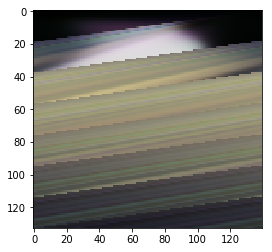

In [18]:
#Showing Flower Results
# pyplot.imshow(X=np.array(Y2_pred).reshape(133,140,3)/np.amax(Y2_pred))
pyplot.imshow(np.array(Y2_pred).reshape(133,140,3))
# pyplot.imshow(np.array(Y2_norm).reshape(133,140,3))
pyplot.show()